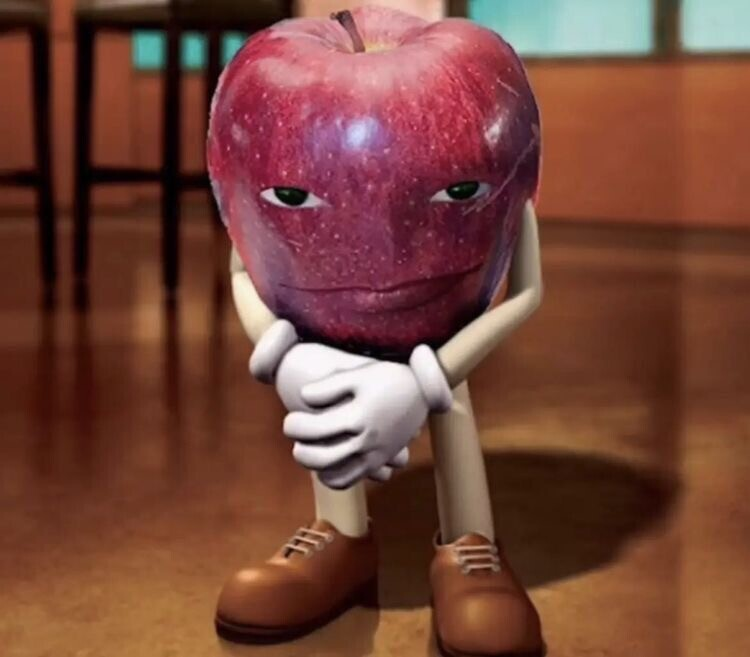

In [44]:
from IPython.display import Image, display
display(Image("https://img-webcalypt.ru/uploads/admin/images/meme-templates/EXAngJAPzOklE4MNLKEtexRme8DnjGzO.jpg"))

# Контекстно-свободная грамматика для языка [Láadan](https://en.wikipedia.org/wiki/L%C3%A1adan)
Правила:
```
start: sentence
sentence: verb_phrase subject_phrase object_phrase? EVIDENCE_PARTICLE? EOS

verb_phrase: SPEECH_ACT_PARTICLE? TENSE_PARTICLE verb_form
verb_form: "me"? VERB
subject_phrase : NOUN | pronoun_marked | adjective_phrase
adjective_phrase: "wo" NOUN "wo" ADJ
pronoun_marked: PRONOUN_STEM "e" | "a" | "i"
object_phrase: NOUN "th"

EOS: "." | "!" | "?"
SPEECH_ACT_PARTICLE: "bíi" | "báa" | "bó" | "bóo" | "bé" | "bée"
TENSE_PARTICLE: "ril" | "eril" | "aril"
EVIDENCE_PARTICLE: "wa" | "wi" | "we" | "wáa" | "waá" | "wo" | "wóo"

NOUN: "bo" | "doyu" | "edan" | "rul"| "with" | "yu"
VERB: "áya" | "thi" | "yod" | "úuya"
ADJ: "áya"
PRONOUN_STEM: "l" | "n" | "b"

%import common.WS
%ignore /([wo]?<!) /
%ignore WS

```

Лаадан-английский словарь словарь:
* Speech-act particles:
 * `bíi`: declarative sentence
 * `báa`: interrogative sentence
 * `bó`: imperative sentence
 * `bóo`: request sentence
 * `bé`: promisse sentence
 * `bée`: warning sentence
* Tense particles:
 * `ril`: present
 * `eril`: past
 * `aril`: future
* Evidential particles:
 * `wa`: known to speaker because perceived by speaker, externally or internally
 * `wi`: known to speaker because self-evident
 * `we`: perceived by speaker in a dream
 * `wáa`: assumed true by speaker because speaker trusts source
 * `waá`: assumed false by speaker because speaker distrusts source; if evil intent by the source is also assumed
 * `wo`: imagined or invented by speaker, hypothetical
 * `wóo`: used to indicate that the speaker states a total lack of knowledge as to the validity of the matter
* Content words:
 * `bo`: mountain
 * `doyu`: apple
 * `edan`: linguistics
 * `rul`: cat
 * `with`: human, woman
 * `yu`: fruit
* Functional words:
 * `a`: to love an inanimate object, love for it
 * `áya`: beautiful, to be beautiful
 * `thi`: to habe
 * `yod`: to eat
  * `úuya`: to hurt, to feel pain
* Pronouns:
 * к местоимениям **обязательно** прибавляется гласная `e/i/a`: `e`: немаркированно, `a`: о любимом человеке, `i`: об уважаемом человеке
 * `l-` : I
 * `n-`: you
 * `b-`: (s)he

In [ ]:
!pip install lark anytree

In [ ]:
from lark import Lark, Tree, Token, Transformer, Visitor

from anytree import Node, RenderTree, find_by_attr

In [ ]:
laadan_grammar = """
start: sentence
sentence: verb_phrase subject_phrase object_phrase? EVIDENCE_PARTICLE? EOS

verb_phrase: SPEECH_ACT_PARTICLE? TENSE_PARTICLE verb_form
verb_form: "me"? VERB
subject_phrase : NOUN | pronoun_marked | adjective_phrase
adjective_phrase: "wo" NOUN "wo" ADJ
pronoun_marked: PRONOUN_STEM "e" | "a" | "i"
object_phrase: NOUN "th"

EOS: "." | "!" | "?"
SPEECH_ACT_PARTICLE: "bíi" | "báa" | "bó" | "bóo" | "bé" | "bée"
TENSE_PARTICLE: "ril" | "eril" | "aril"
EVIDENCE_PARTICLE: "wa" | "wi" | "we" | "wáa" | "waá" | "wo" | "wóo"

NOUN: "bo" | "doyu" | "edan" | "rul"| "with" | "yu"
VERB: "áya" | "thi" | "yod" | "úuya"
ADJ: "áya"
PRONOUN_STEM: "l" | "n" | "b"

%import common.WS
%ignore /([wo]?<!) /
%ignore WS
"""

laadan_parser = Lark(laadan_grammar, start='start')

In [ ]:
sent = "bíi eril yod le doyuth wa." # я съела яблоко
tree = laadan_parser.parse(sent)
print(tree.pretty())

start
  sentence
    verb_phrase
      bíi
      eril
      verb_form	yod
    subject_phrase
      pronoun_marked	l
    object_phrase	doyu
    wa
    .



# Дерево

In [ ]:
def tree_to_anytree(lark_node, parent=None):
    if isinstance(lark_node, Tree):
        node = Node(lark_node.data, parent=parent)
        for child in lark_node.children:
            tree_to_anytree(child, parent=node)
        return node
    elif isinstance(lark_node, Token):
        return Node(f"{lark_node.type}: {lark_node.value}", parent=parent)

anytree_root = tree_to_anytree(laadan_parser.parse("bíi eril yod le doyuth wa."))
for pre, _, node in RenderTree(anytree_root):
    print(f"{pre}{node.name}")

start
└── sentence
    ├── verb_phrase
    │   ├── SPEECH_ACT_PARTICLE: bíi
    │   ├── TENSE_PARTICLE: eril
    │   └── verb_form
    │       └── VERB: yod
    ├── subject_phrase
    │   └── pronoun_marked
    │       └── PRONOUN_STEM: l
    ├── object_phrase
    │   └── NOUN: doyu
    ├── EVIDENCE_PARTICLE: wa
    └── EOS: .


# Переводчик
но такой если бы в английском все глаголы спрягались как слабые

In [ ]:
def translate(s: str):
    dictionary = {
        "l":"I",
        "n": "you",
        "d": "they",

        "bo": "mountain",
        "doyu": "apple",
        "edan": "linguistics",
        "rul": "cat",
        "with": "woman",
        "yu": "fruit",

        "a": "love",
        "áya": "beautiful",
        "thi": "have",
        "yod": "eat",
        "úuya": "hurt"
    }
    return dictionary[s]


class SimpleTranslator(Visitor):
    def __init__(self):
        self.subject = None
        self.verb = None
        self.obj = None
        self.tense = None
        self.act = None
        self.eos = None


    def __default__(self, node):
        if node.data == "object_phrase":
            self.obj = translate(node.children[0].value)
        elif node.data == "subject_phrase":
            n = node.children[0]
            if isinstance(n, Token):
                self.subject = translate(n.value)
            elif n.data == "pronoun_marked":
                self.subject = translate(n.children[0].value)
            elif n.data == "adjective_phrase":
                self.subject = translate(n.children[1].value) + " " + translate(n.children[0].value)
        elif node.data == "verb_phrase":
            for n in node.children:
                if isinstance(n, Token) and n.type == "SPEECH_ACT_PARTICLE":
                    self.act = n.value
                elif isinstance(n, Token) and n.type == "TENSE_PARTICLE":
                    self.tense = n.value
                elif isinstance(n, Tree) and n.data == "verb_form":
                    self.verb = translate(n.children[0].value)
        elif node.data == "sentence":
            for n in node.children:
                if isinstance(n, Token) and n.type == "EOS":
                    self.eos = n.value

    def get_result(self):
        # print(self.obj, self.subject, self.verb, self.tense, self.act, self.eos)
        leading_group = self.subject + " " + self.verb
        if self.tense == "ril" and self.act == "báa":
            leading_group = "Do " + leading_group
        elif self.tense == "eril" and self.act == "báa":
            leading_group = "Did " + leading_group
        elif self.tense == "eril" and self.act != "báa":
            leading_group = leading_group+"ed"
        elif self.tense == "aril" and self.act == "báa":
            leading_group = "Will " + leading_group
        elif self.tense == "aril" and self.act != "báa":
            leading_group = self.subject + " will " + self.verb
        return leading_group+(" "+self.obj if self.obj != None else "")+self.eos

In [ ]:
sentence_tree = laadan_parser.parse("bíi aril yod le doyuth wa.")
tr = SimpleTranslator()
tr.visit(sentence_tree)
print(tr.get_result())

I will eat apple.
